# 0.0. Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import model_selection as ms
from sklearn import neighbors as ng
from sklearn import linear_model as lm
from sklearn import ensemble as en

## 0.1. Helper Functions

In [3]:
def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[k, 'precision_at_k'], data)


def recall_at_k( data, k ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )


def perfomance_metrics_at_k(x_val, y_val, yhat, model_name, percentage_of_base):  
    df = x_val.copy()
    df['response'] = y_val
    df['score'] = yhat[:, 1].tolist()
    df = df.sort_values( 'score', ascending=False )

    k = int(percentage_of_base * df.shape[0])

    precision,  data = precision_at_k(df, k)
    recall, data = recall_at_k(df, k)

    return pd.DataFrame({'model_name': [model_name],
                         'Precision@K': [round(precision, 3)],
                         'Recall@K': [round(recall, 3)]}, index=[0])

def descriptive_statistics(num_attributes):
    # ct: mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean))
    ct2 = pd.DataFrame(num_attributes.apply(np.median))

    # dispersion: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.min))
    d2 = pd.DataFrame(num_attributes.apply(np.max))
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ))
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.std() ))
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() ))
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() ))

    # concat
    m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6], axis=1).reset_index()
    m.columns = ['atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
    return m

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
df_raw = pd.read_csv('../data/raw/train.csv')

# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

*  **Id:** identificador único do cliente.
*  **Gender:** gênero do cliente.
*  **Age:** idade do cliente.
*  **Driving License:** 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
*  **Region Code:** código da região do cliente.
*  **Previously Insured:** 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
*  **Vehicle Age:** idade do veículo.
*  **Vehicle Damage:** 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
*  **Anual Premium:** quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
*  **Policy sales channel:** código anônimo para o canal de contato com o cliente.
*  **Vintage:** número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
*  **Response:** 0, o cliente não tem interesse e 1, o cliente tem interesse.

## 1.1. Rename Columns

In [7]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print(f'Number Of Rows: {df1.shape[0]}')
print(f'Number Of Columns: {df1.shape[1]}')

Number Of Rows: 381109
Number Of Columns: 12


## 1.3. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Statistical Descriptive

In [11]:
num_atr = df1.select_dtypes(include=['int64', 'float64'])
cat_atr = df1.select_dtypes(include=['object'])

### 1.5.1. Numerical Attributes

In [12]:
descriptive_statistics(num_atr)

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.836208,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511611,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046110,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229888,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.155057,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203995,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671304,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327936,2.301906e+00,3.298788


### 1.5.2. Categorical Attributes

In [13]:
columns = ['gender', 'vehicle_age', 'vehicle_damage', 'driving_license', 'response', 'previously_insured']
for column in columns:
    print(f'[ {column} ]: ')
    display(df1[column].value_counts(normalize=True))

[ gender ]: 


Male      0.540761
Female    0.459239
Name: gender, dtype: float64

[ vehicle_age ]: 


1-2 Year     0.525613
< 1 Year     0.432385
> 2 Years    0.042001
Name: vehicle_age, dtype: float64

[ vehicle_damage ]: 


Yes    0.504877
No     0.495123
Name: vehicle_damage, dtype: float64

[ driving_license ]: 


1    0.997869
0    0.002131
Name: driving_license, dtype: float64

[ response ]: 


0    0.877437
1    0.122563
Name: response, dtype: float64

[ previously_insured ]: 


0    0.54179
1    0.45821
Name: previously_insured, dtype: float64

# 2.0. Feature Engineering

In [14]:
df2 = df1.copy()

## 2.1. Feature Creation

In [15]:
# gender
gender_map = {'Male': 1, 'Female': 0}
df2.loc[:, 'gender'] = df2['gender'].map(gender_map)

# vehicle_age
vehicle_age_map = {'1-2 Year': 'between_1_2_years', '< 1 Year': 'bellow_1_year', '> 2 Years': 'over_2_year'}
df2.loc[:, 'vehicle_age'] = df2['vehicle_age'].map(vehicle_age_map)

# vehicle_damage
vehicle_damage_map = {'Yes': 1, 'No': 0}
df2.loc[:, 'vehicle_damage'] = df2['vehicle_damage'].map(vehicle_damage_map)

# 3.0. Data Filtering

In [16]:
df3 = df2.copy()

# 4.0. EDA

In [17]:
df4 = df3.copy()

## 4.1. Univariate Analysis

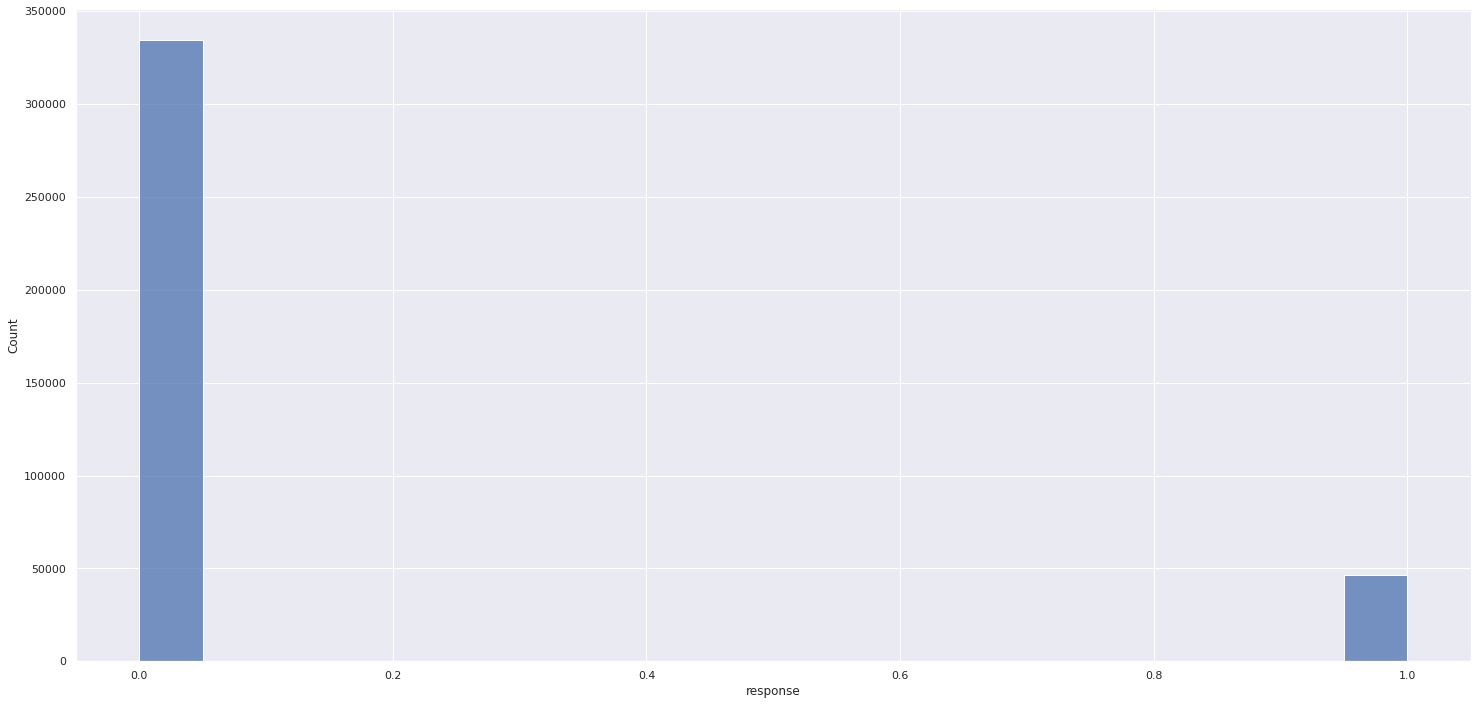

In [19]:
sns.histplot(df4['response']);

<AxesSubplot:xlabel='policy_sales_channel', ylabel='Count'>

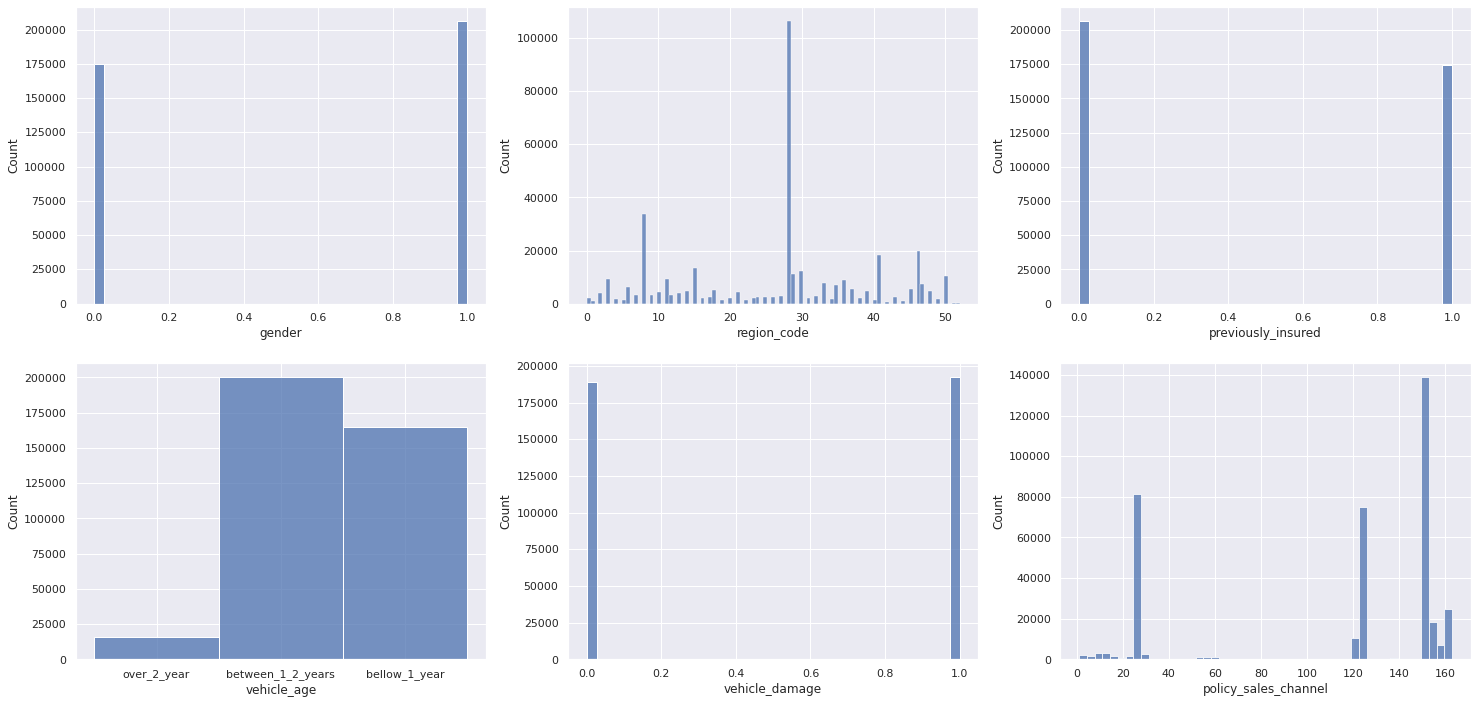

In [32]:
plt.subplot(2,3,1)
sns.histplot(df4['gender'])

plt.subplot(2,3,2)
sns.histplot(df4['region_code'])

plt.subplot(2,3,3)
sns.histplot(df4['previously_insured'])

plt.subplot(2,3,4)
sns.histplot(df4['vehicle_age'])

plt.subplot(2,3,5)
sns.histplot(df4['vehicle_damage'])

plt.subplot(2,3,6)
sns.histplot(df4['policy_sales_channel'])

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

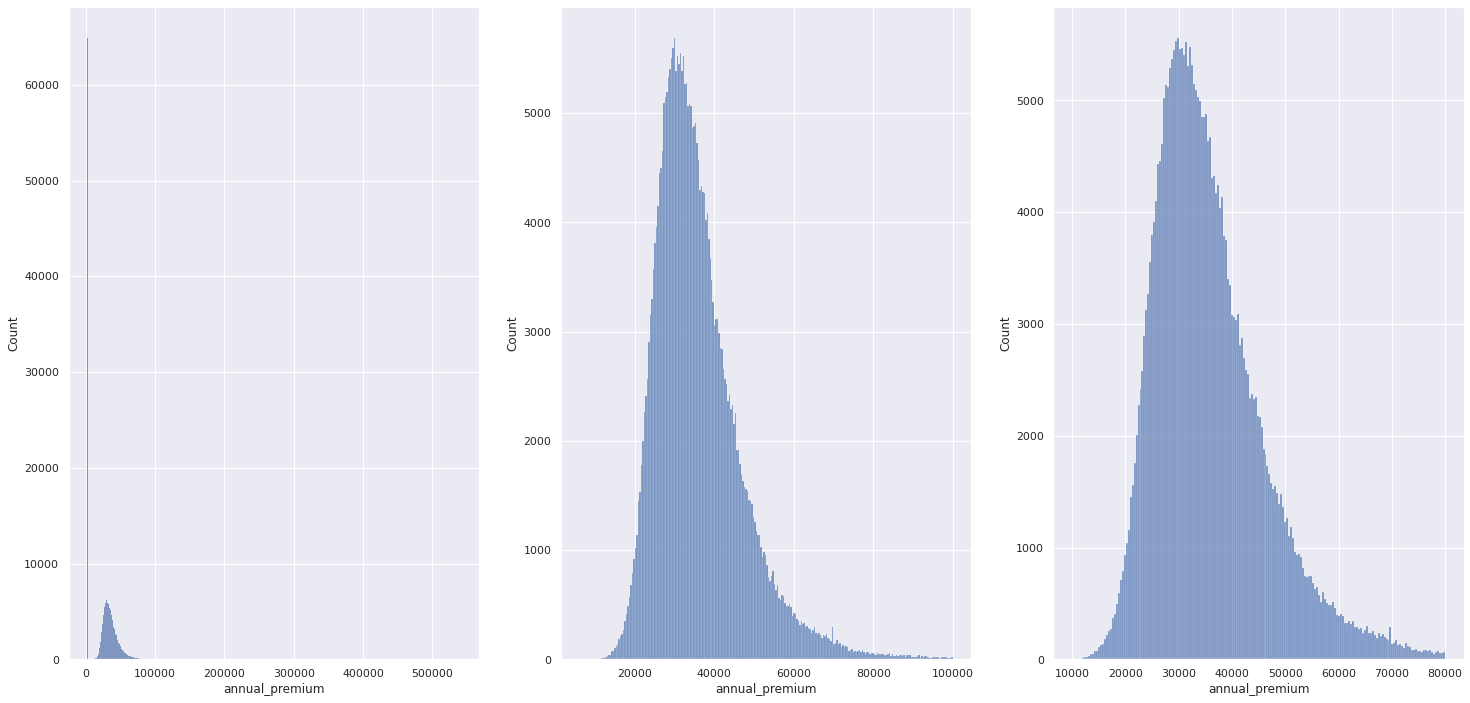

In [66]:
plt.subplot(1,3,1)
sns.histplot(df4['annual_premium'])

plt.subplot(1,3,2)
aux1 = df4[(df4['annual_premium'] > 3000.0) & (df4['annual_premium'] <= 100000.0)].copy()
sns.histplot(aux1['annual_premium'])

plt.subplot(1,3,3)
aux2 = df4[(df4['annual_premium'] > 10000.0) & (df4['annual_premium'] <= 80000.0)].copy()
sns.histplot(aux2['annual_premium'])

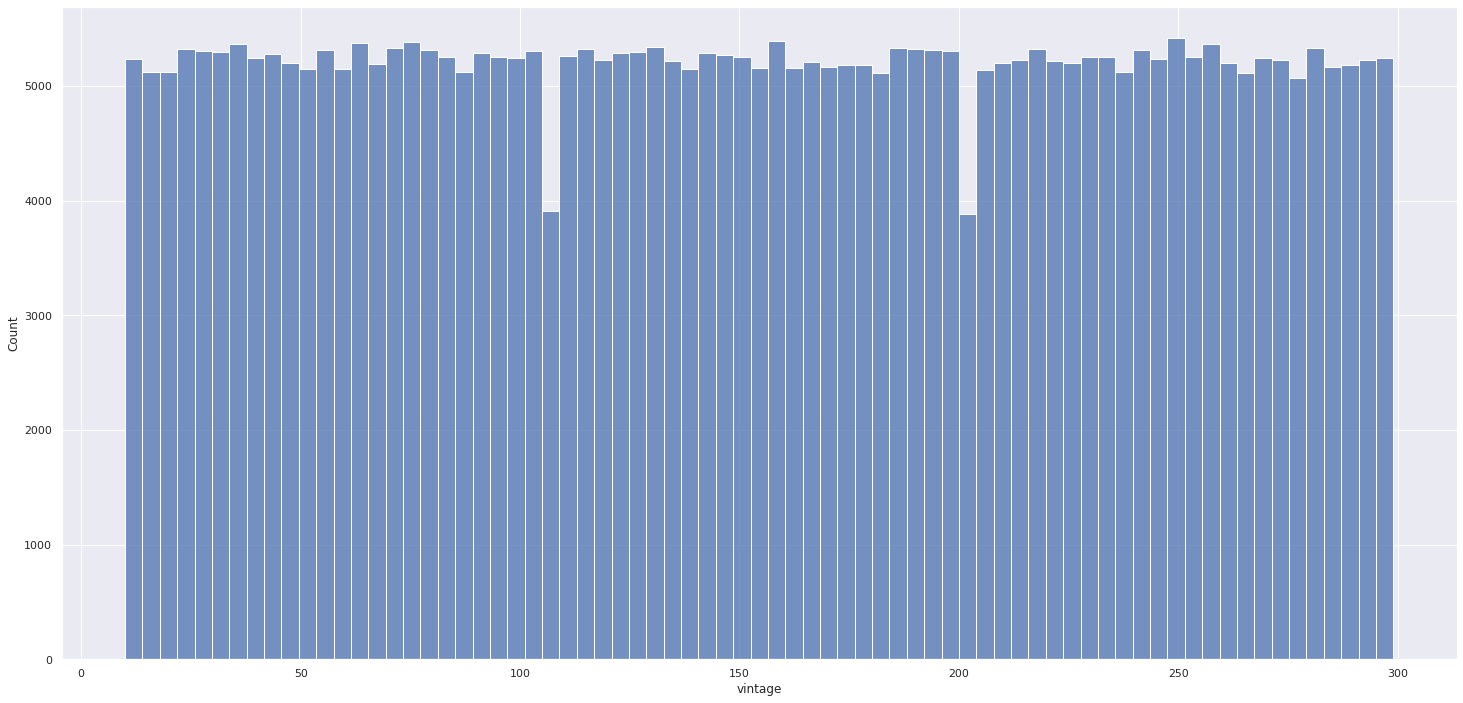

In [58]:
sns.histplot(aux['vintage']);

## 4.1. Bivariave Analysis

 ## Hipóteses

* **Gender:** Mulheres têm mais interesse em adquirir o seguro que homens
* **Age:** Pessoas acima de 40 anos tem mais interesse em adquirir o seguro
* **Driving License:** Pessoas com habilitação tem mais interesse em adquirir o seguro.
* **Region Code:** - 
* **Previously Insured:** Cliente que já tem seguro de automóveis tem mais interesse em migrar para o novo.
* **Vehicle Age:** Donos de veículos mais antigos, têm menos interesse em adquirir o seguro.
* **Vehicle Damage:** Pessoas que já tiveram seu veículo danificado, têm mais interesse em adquirir o seguro.
* **Anual Premium:** Quanto maior o valor do prêmio, mais interesse em adquirir o seguro.
* **Policy sales channel:** - 
* **Vintage:** -

# 5.0. Data Preparation

In [11]:
X = df4.drop(['response', 'id'], axis=1).copy()
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Standardization

## 5.2. Rescaling

## 5.3. Encoding

In [12]:
df5 = pd.get_dummies(df5, columns=['vehicle_age'], prefix=['vehicle_age'])

## 5.4. Data Preparation - Validation 

In [13]:
x_validation = pd.get_dummies(x_validation, columns=['vehicle_age'], prefix=['vehicle_age'])

# 6.0. Feature Selection

In [14]:
cols_selected = ['gender', 'age', 'driving_license', 'region_code', 
                 'previously_insured','vehicle_damage', 'annual_premium', 
                 'policy_sales_channel', 'vintage', 'vehicle_age_bellow_1_year',
                 'vehicle_age_between_1_2_years', 'vehicle_age_over_2_year']

# 7.0. Machine Learning Modelling

In [15]:
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1. KNN

In [16]:
# model definition and fit
model_knn = ng.KNeighborsClassifier().fit(x_train, y_train)

# Predictions
yhat_knn = model_knn.predict_proba(x_val)

# Performance
result_knn = perfomance_metrics_at_k(x_val, y_val, yhat_knn, 'KNeighborsClassifier', 0.2)
result_knn

## 7.2. Logistic Regression

In [28]:
# model definition and fit
model_lr = lm.LogisticRegression().fit(x_train, y_train)

# predictions
yhat_lr = model_lr.predict_proba(x_val)

# Performance
result_lr = perfomance_metrics_at_k(x_val, y_val, yhat_lr, 'LogisticRegression', 0.2)
result_lr

/home/cid/.pyenv/versions/3.8.0/envs/health-insurance-cross-sell-prediction/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,Precision@K,Recall@K
0,LogisticRegression,0.228,0.375


## 7.3. Extra Trees Classifier

In [23]:
# model definition and fit
model_et = en.ExtraTreesClassifier().fit(x_train, y_train)

# predictions
yhat_et = model_et.predict_proba(x_val)

# Perfomance
result_et = perfomance_metrics_at_k(x_val, y_val, yhat_et, 'ExtraTreesClassifier', 0.2 )
result_et

## 7.4. Random Forest Classifier

In [26]:
model_rf = en.RandomForestClassifier().fit(x_train, y_train)

yhat_rf = model_rf.predict_proba(x_val)

result_rf = perfomance_metrics_at_k(x_val, y_val, yhat_rf, 'RandomForestClassifier', 0.2)
result_rf

## 7.5.  XGBoost Classifier

In [35]:
# model definition and fit
model_xgb = xgb.XGBClassifier().fit(x_train, y_train)

# predictions
yhat_xgb = model_xgb.predict_proba(x_val)

# Perfomance
result_xgb = perfomance_metrics_at_k(x_val, y_val, yhat_xgb, 'XGBClassifier', 0.2)
result_xgb

,model_name,Precision@K,Recall@K
0,XGBClassifier,0.354,0.581


## 7.6. Machine Learning Model's Performance

In [39]:
result = pd.concat([result_knn, result_lr, result_et, result_rf, result_xgb]).sort_values('Recall@K', ascending=False)
result

,model_name,Precision@K,Recall@K
0,XGBClassifier,0.354,0.581
0,RandomForestClassifier,0.320,0.526
0,ExtraTreesClassifier,0.316,0.519
0,LogisticRegression,0.228,0.375
0,KNeighborsClassifier,0.183,0.301
